In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [98]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9
                  , -8, -7
                 ], np.nan, inplace=True)

# Drop columns with correlation over 0.8 with lower feature importance
to_remove = ['NumTotalTrades', 'NumTrades90Ever/DerogPubRec', 'NumInqLast6Mexcl7days'] 
features = features.drop(to_remove, axis=1)

# the columns that stores the labels
labelDimension = "RiskPerformance"

original_rows = features.shape[0]

features = features.dropna(thresh=10) # Remove rows with more than 10 missing values
print("Removed rows:", original_rows - features.shape[0])
features.drop(features.columns[features.isnull().sum() > 1000], axis=1, inplace=True) # Drop columns with more than 1000 values missing

# bins = [0, 20, 40, 60, 80, 100]
# labels =[0, 1, 2, 3, 4]
# features['ExternalRiskEstimateCat'] = pd.cut(features['ExternalRiskEstimate'], bins, labels=labels)

categorical = [
#     'ExternalRiskEstimateCat', 
    'MaxDelqEver', 
    'MaxDelq/PublicRecLast12M'
]

X = features[features.columns[1:]]
numerical = [col for col in X.columns if col not in categorical]

y = features[labelDimension]
y_code = y.astype("category").cat.codes # Int representation of labels
for cat in categorical:
    X[cat] = X[cat].astype("category")

Removed rows: 588


C:\Users\adubo\AppData\Local\Temp\ipykernel_39348\1555536448.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\adubo\AppData\Local\Temp\ipykernel_39348\1555536448.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

imputer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical), 
    ('cat', SimpleImputer(strategy='most_frequent'), categorical)
])

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transformer = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])

In [101]:
columns = list(numerical) + list(categorical)

X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.9, random_state=0)

# Impute values
X_np = imputer.fit_transform(X)
X = pd.DataFrame(X_np, columns=columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.9, random_state=0)

In [104]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
labelled_correctly = y_pred == y_test
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# import plotly.express as px

# pca = PCA()
# components = pca.fit_transform(X_test_transformed)
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix( 
#     corrMatrix,
#     labels=X_train.columns,
#     dimensions=X_train.columns
# )
# fig.update_traces(diagonal_visible=True)
# fig.show()

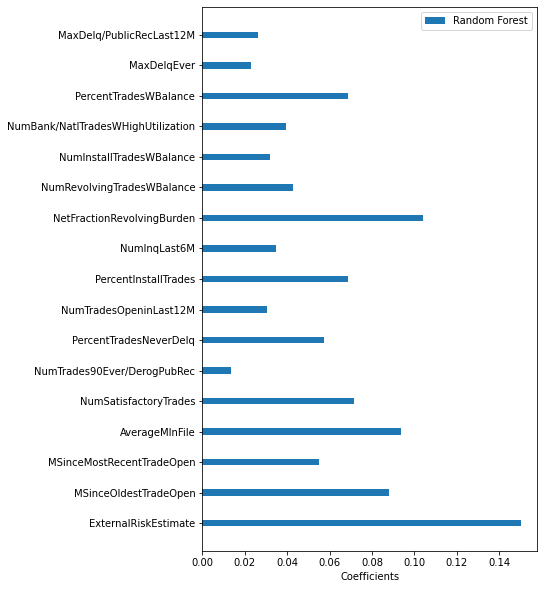

In [106]:
# Feature importances
df = pd.DataFrame({'names': columns, 
                   'random_forest': model.feature_importances_})

fig, ax = plt.subplots(figsize=(6, 10))
ind = np.arange(len(df))
width = 0.2
ax.barh(ind, df.random_forest, width, label='Random Forest')
ax.set_yticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Permutation Importances (test set)')

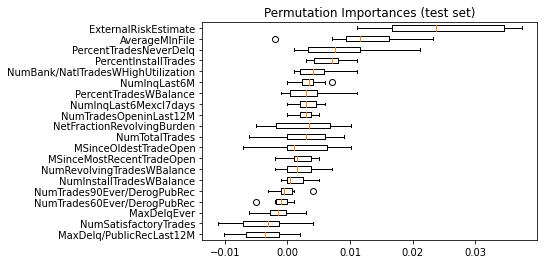

In [6]:
# Permutation Importances
from sklearn.inspection import permutation_importance
 
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0) # Takes a long time
sorted_idx = perm_importance.importances_mean.argsort()
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=np.array(columns)[sorted_idx])
plt.title("Permutation Importances (test set)")

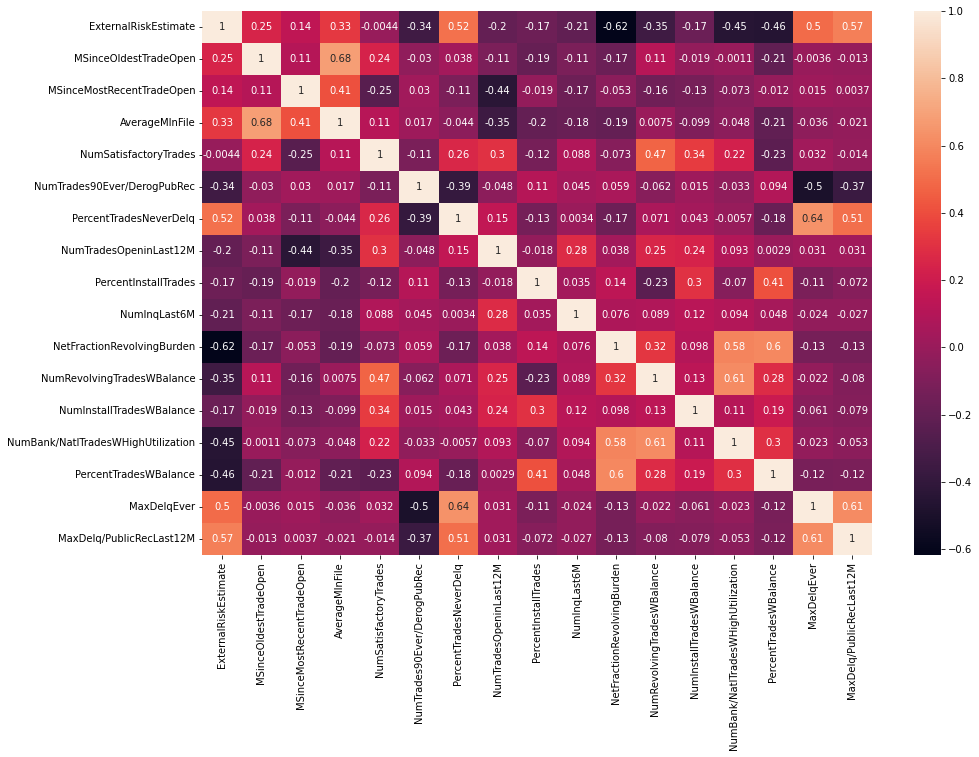

In [105]:
# Correlation matrix
import seaborn as sn
corrMatrix = X_train.corr()
plt.figure(figsize=(15, 10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

In [21]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4).fit(X_test_transformed)
# clustering_labels = kmeans.labels_
# plt.scatter(X_embed[:, 0], X_embed[:, 1], c=clustering_labels, s=1)
# plt.colorbar()

In [22]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=5, min_samples=20).fit(X_test_transformed)
# clustering_labels = dbscan.labels_

In [100]:
X_embed

array([[-20.995594  ,  59.456142  ],
       [ -2.400362  ,  42.214195  ],
       [-15.916271  ,  41.662903  ],
       ...,
       [-33.388233  ,  40.796864  ],
       [ -0.85045886,  18.548758  ],
       [ 23.284906  , -49.410477  ]], dtype=float32)

In [99]:
X_test_transformed.shape

(1975, 20)

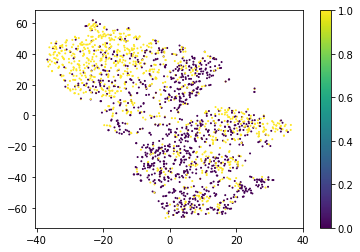

In [67]:
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_test, s=1)
plt.colorbar()

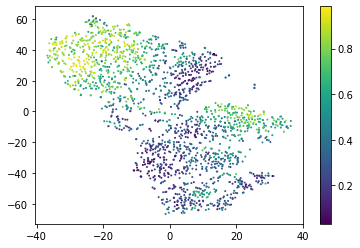

In [23]:
# Plot prediction probabilities across samples - also allow for other params!
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred_prob, s=1)
plt.colorbar()

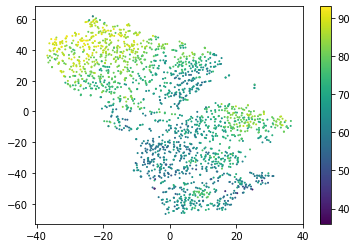

In [39]:
# labels - any of the col names
labels = X_test['ExternalRiskEstimate'].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()


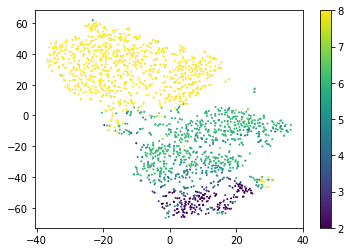

In [40]:
labels = X_test[categorical[0]].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

In [15]:
# from sklearn.decomposition import PCA
# import plotly.express as px

# pca = PCA()
# components = pca.fit_transform(X_test_transformed)
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix( 
#     components,
#     labels=labels,
#     dimensions=range(4),
#     color=y_pred_prob
# )
# fig.update_traces(diagonal_visible=True)
# fig.show()

In [17]:
# pca = PCA(n_components=2)
# components = pca.fit_transform(X_test_transformed)

# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# fig = px.scatter(components, x=0, y=1, color=y_pred_prob)


# for i, dim in enumerate(X.columns.tolist()):
#     fig.add_shape(
#         type='line',
#         x0=0, y0=0,
#         x1=loadings[i, 0],
#         y1=loadings[i, 1]
#     )
#     fig.add_annotation(
#         x=loadings[i, 0],
#         y=loadings[i, 1],
#         ax=0, ay=0,
#         xanchor="center",
#         yanchor="bottom",
#         text=dim,
#     )
# fig.show()

In [30]:
# DiCE counterfactual explanations
from dice_ml import Data, Model, Dice

df = X_train.copy()
df['y'] = y_train
data = Data(
    dataframe=df, 
    continuous_features=numerical, 
    outcome_name='y'
)
m = Model(model=model, backend='sklearn')
dice = Dice(data, m, method='random')

In [31]:
e = dice.generate_counterfactuals(X_test[:1], total_CFs=1, desired_class="opposite")

# As an improvement point for the future work in the report - 
# would be great if we could get counterfactual probability as well, it is a work in progress in the DiCE library

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


In [32]:
e.visualize_as_dataframe(show_only_changes=True)
# Can we show it on 2D plane?

Query instance (original outcome : 1)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever/DerogPubRec,NumTrades90Ever/DerogPubRec,PercentTradesNeverDelq,NumTotalTrades,NumTradesOpeninLast12M,...,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank/NatlTradesWHighUtilization,PercentTradesWBalance,MaxDelqEver,MaxDelq/PublicRecLast12M,y
0,72.0,334.0,2.0,69.0,19.0,0.0,0.0,100.0,59.0,4.0,...,2.0,2.0,51.0,3.0,2.484906,1.0,50.0,8.0,7.0,1



Diverse Counterfactual set (new outcome: 0.0)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever/DerogPubRec,NumTrades90Ever/DerogPubRec,PercentTradesNeverDelq,NumTotalTrades,NumTradesOpeninLast12M,...,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank/NatlTradesWHighUtilization,PercentTradesWBalance,MaxDelqEver,MaxDelq/PublicRecLast12M,y
0,-,-,-,-,-,-,-,-,-,-,...,-,-,151.3,-,3.084905660377359,-,-,-,-,0


In [42]:
import json

d = json.loads(e.to_json())

In [62]:
cfs_list = d['cfs_list'][0][0][:20]

In [63]:
cfs_list

[72.0,
 334.0,
 2.0,
 69.0,
 19.0,
 0.0,
 0.0,
 100.0,
 59.0,
 4.0,
 15.0,
 2.0,
 2.0,
 151.3,
 3.0,
 3.084905660377359,
 1.0,
 50.0,
 8.0,
 7.0]

In [67]:
test_data = d['test_data'][0][0][:20]

In [107]:
cf_df = pd.DataFrame([test_data, cfs_list], columns=d['feature_names'], index=['Actual', 'Closest CounterFactual'])

In [108]:
nunique = cf_df.nunique()
cols_to_drop = nunique[nunique == 1].index
cf_df.drop(cols_to_drop, axis=1)

,NetFractionRevolvingBurden,NumInstallTradesWBalance
Actual,51.0,2.484906
Closest CounterFactual,151.3,3.084906


In [63]:
e.visualize_as_list(show_only_changes=True)

Query instance (original outcome : 0)
[75.0, 113.0, 97.0, 105.0, 2.0, 0.0, 0.0, 100.0, 2.0, 0.0, 0.0, 0.0, 0.0, 101.0, 2.0, 2.4849056603773585, 1.0, 100.0, 8.0, 7.0, 0.0]

Diverse Counterfactual set (new outcome: 1.0)
['-', '-', '-', '-', 44.8, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 3.084905660377359, '-', '-', '-', '-', 1]
['-', '-', '-', '-', 65.9, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 10.5, '-', '-', '-', '-', 1]


In [7]:
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)[1] #Takes a very long time

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.dependence_plot("ExternalRiskEstimate", shap_values, X_test)

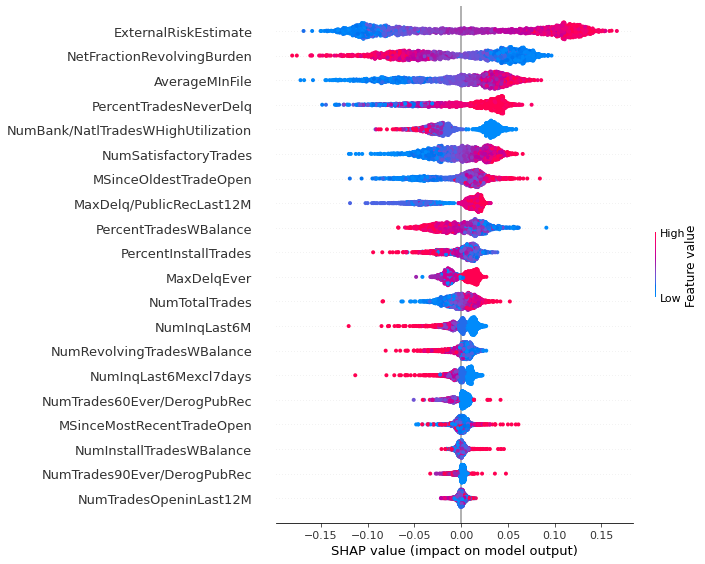

In [91]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [96]:
from lime.lime_tabular import LimeTabularExplainer

# X_train = X_train.drop('y', axis=1)
explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train.columns, 
    verbose=True
)

In [97]:
exp = explainer.explain_instance(X_test.values[1], model.predict_proba)
exp.show_in_notebook(show_table=True)

Intercept 0.4194337465672764
Prediction_local [0.51954655]
Right: 0.6646666666666666


In [85]:
exp.as_list()

[('ExternalRiskEstimate > 80.00', 0.09796771597000616),
 ('AverageMInFile <= 57.00', -0.0754769515230317),
 ('97.00 < PercentTradesNeverDelq <= 100.00', 0.0522093909581925),
 ('NumSatisfactoryTrades <= 13.00', -0.04239183699472913),
 ('MSinceOldestTradeOpen <= 136.75', -0.03623764582651321),
 ('9.00 < NetFractionRevolvingBurden <= 31.00', 0.03133085386927697),
 ('NumBank/NatlTradesWHighUtilization <= 0.00', 0.027387802551761382),
 ('6.00 < MaxDelqEver <= 8.00', 0.020210989464546886),
 ('6.00 < MaxDelq/PublicRecLast12M <= 7.00', 0.019804323834041185),
 ('PercentTradesWBalance <= 50.00', 0.01867811591496981)]

In [88]:
exp.predict_proba

array([0.33533333, 0.66466667])